# Lab 3: Logistic Regression

### Dataset: 
Predicting the weather: https://www.kaggle.com/datasets/ananthr1/weather-prediction

Or maybe driving style: https://www.kaggle.com/datasets/outofskills/driving-behavior

Group: Benjamin Kuo & Nick Benso

## Preparation and Overview (3 points total)
[2 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? As in previous labs, also detail how good the classifier needs to perform in order to be useful. 

[.5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Provide a breakdown of the variables after preprocessing (such as the mean, std, etc. for all variables, including numeric and categorical).


[.5 points] Divide your data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?

In [60]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

df = pd.read_csv('seattle-weather.csv') # read in the csv file
print(df.info())

# separate data types
date_features = 'date'
numerical_features = ['precipitation','temp_max','temp_min','wind']
weather_features = ['weather']
df['weather'].replace(['drizzle', 'fog', 'rain', 'snow', 'sun'],
                        [0, 1, 2, 3, 4], inplace=True)

# define with correct data types
del df['date']
df[numerical_features] = df[numerical_features].astype(np.float64)
df[weather_features] = df[weather_features].astype(np.int64)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1461 non-null   float64
 1   temp_max       1461 non-null   float64
 2   temp_min       1461 non-null   float64
 3   wind           1461 non-null   float64
 4   weather        1461 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 57.2 KB


In [61]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'weather' in df:
    y = df['weather'].to_numpy() # get the labels we want
    del df['weather'] # get rid of the class label
    
    norm_features = ['precipitation', 'temp_max', 'temp_min', 'wind' ]
    df[norm_features] = (df[norm_features]-df[norm_features].mean()) / df[norm_features].std()
    X = df.to_numpy() # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


## Modeling (5 points total)
The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 

[2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and {Newton's method/Quasi Newton methods}. 
Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

[1.5 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? 

[1.5 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 

In [62]:
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, C, iterations=20):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction




class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing  

            
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    

from scipy.optimize import fmin_bfgs # maybe the most common bfgs algorithm in the world
from numpy import ma
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

            
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient




# now lets do some vectorized coding
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_intercept=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)


class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,
                                                 self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver=BFGSBinaryLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = self.solver(eta=self.eta,iterations=self.iters,C=self.C)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

    
class RegularizedBinaryLogisticRegression(VectorBinaryLogisticRegression):
    # extend init functions
    def __init__(self, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
        
        
    # extend previous class to change functionality
    def _get_gradient(self,X,y):
        # call get gradient from previous class
        gradient = super()._get_gradient(X,y)
        
        # add in regularization (to all except bias term)
        gradient[1:] += -2 * self.w_[1:] * self.C
        return gradient


class RegularizedLogisticRegression(LogisticRegression):
    def __init__(self, C=0.0, **kwds):        
        # need to add to the original initializer 
        self.C = C
        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            # now this has regularization built into it
            blr = RegularizedBinaryLogisticRegression(eta=self.eta,
                                                      iterations=self.iters,
                                                      C=self.C)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T  

In [63]:
from sklearn import metrics as mt
lr_clf = MultiClassLogisticRegression(eta=0.1,iterations=10)
iter_num = 0
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.7986348122866894
confusion matrix
 [[  0   0   1   0   7]
 [  0   0   3   0  19]
 [  0   0 107   0  18]
 [  0   0   1   0   1]
 [  0   0   9   0 127]]
====Iteration 1  ====
accuracy 0.764505119453925
confusion matrix
 [[  0   0   2   0   5]
 [  0   0   2   0  21]
 [  0   0 124   0  26]
 [  0   0   5   0   1]
 [  0   0   7   0 100]]
====Iteration 2  ====
accuracy 0.7679180887372014
confusion matrix
 [[  0   0   0   0  15]
 [  0   0   4   0  15]
 [  0   0 110   0  19]
 [  0   0   2   0   0]
 [  0   0  13   0 115]]


In [104]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.metrics import accuracy_score
def lr_explor(cost, theSolver):
    lr_clf = MultiClassLogisticRegression(eta=0.1,iterations=10,
                                            C=float(cost), solver = theSolver) # get object
    acc = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        lr_clf.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr_clf.predict(X[test_indices]) # get test set predictions
        acc.append(mt.accuracy_score(y[test_indices],y_hat))
        
    acc = np.array(acc)
    return acc

def lr_explor_sklearn():

    lr_sk = SKLogisticRegression(solver='liblinear') # all params default
    acc = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
        lr_sk.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr_sk.predict(X[test_indices]) # get test set predictions
        acc.append(mt.accuracy_score(y[test_indices],y_hat))
    
    acc = np.array(acc)
    return acc

In [91]:
%%time
costs = np.logspace(-5,1,20)
steepestAscent = []
for c in costs:
    steepestAscent.append(lr_explor(c,BinaryLogisticRegression))

stochasticGradientAscent = []
for c in costs:
    stochasticGradientAscent.append(lr_explor(c,StochasticLogisticRegression))

newton = []
for c in costs:
    newton.append(lr_explor(c,HessianBinaryLogisticRegression))

quasiNewton = []
for c in costs:
    quasiNewton.append(lr_explor(c,BFGSBinaryLogisticRegression))


KeyboardInterrupt: 

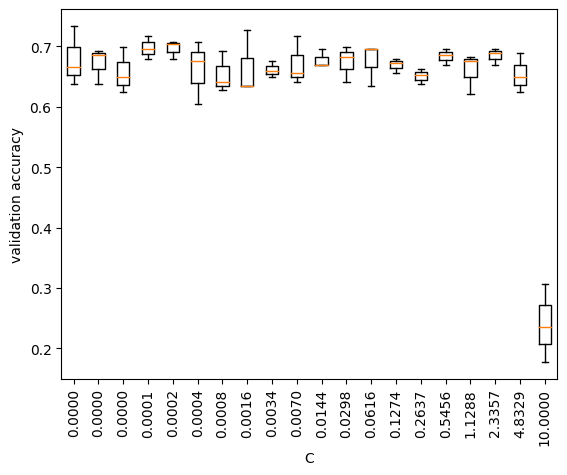

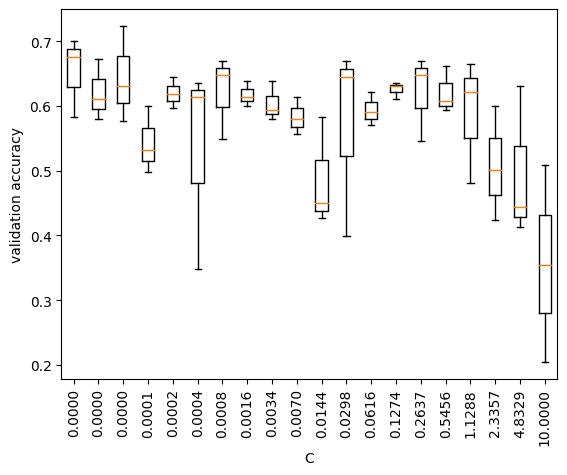

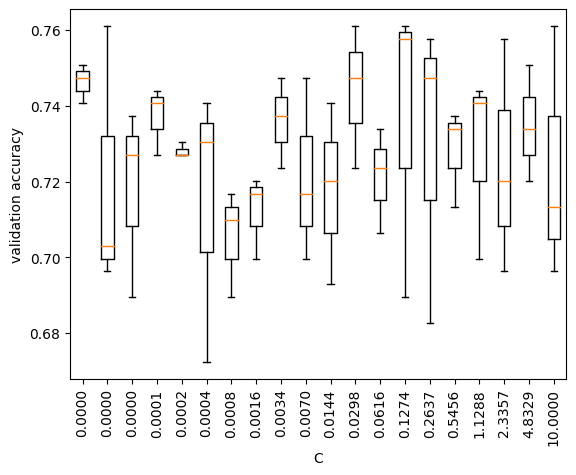

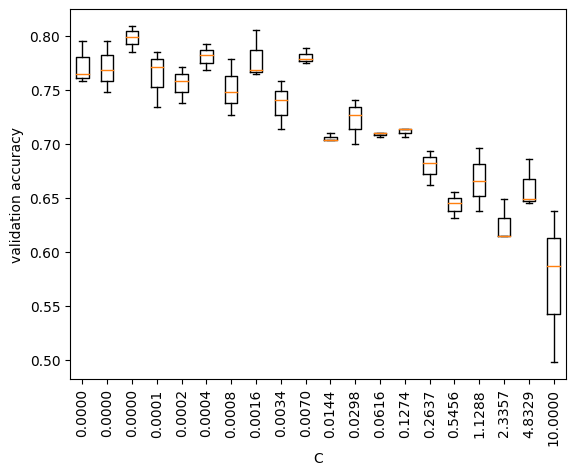

In [82]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.boxplot(steepestAscent)
plt.xticks(range(1,len(costs)+1),['%.4f'%(c) for c in costs],rotation='vertical')
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()


plt.boxplot(stochasticGradientAscent)
plt.xticks(range(1,len(costs)+1),['%.4f'%(c) for c in costs],rotation='vertical')
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()

plt.boxplot(newton)
plt.xticks(range(1,len(costs)+1),['%.4f'%(c) for c in costs],rotation='vertical')
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()

plt.boxplot(quasiNewton)
plt.xticks(range(1,len(costs)+1),['%.4f'%(c) for c in costs],rotation='vertical')
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()

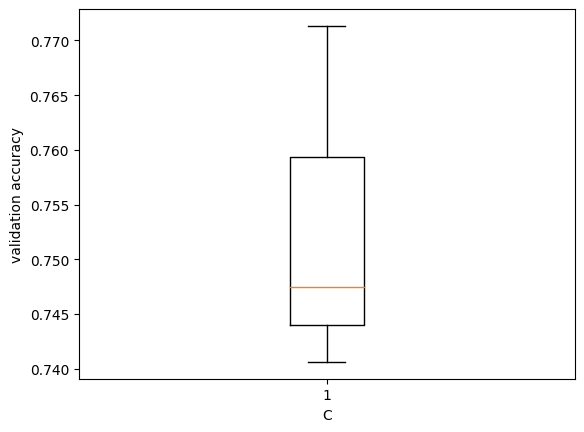

CPU times: total: 141 ms
Wall time: 177 ms


In [108]:
%%time
sklearnOptimization = lr_explor_sklearn()
plt.boxplot(sklearnOptimization)
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()

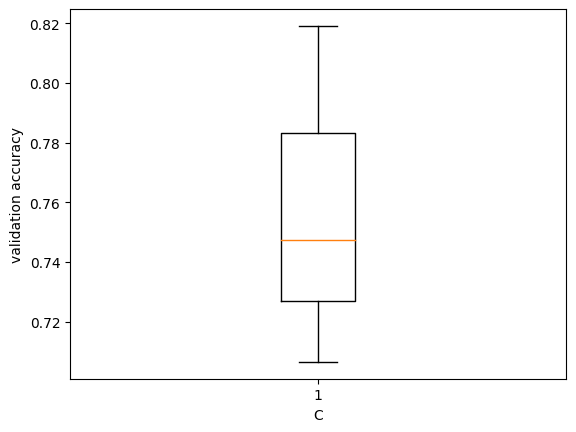

CPU times: total: 109 ms
Wall time: 281 ms


In [107]:
%%time
bestOptimization = lr_explor(.0004,BFGSBinaryLogisticRegression)
plt.boxplot(bestOptimization)
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()

## Deployment (1 points total)
Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?